# TF - IDF Logistic Regression Baseline

 I wanted to check that dependency on lexical features for baseline for hate speech detection will be enough or we need contextual features to analyze the sentiment.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

## Data Loading

Used the CSV specifically preprocessed for the baseline machine learning models to train. These dataset is cleaned after ```stopword removal, demojizing, url removal, placeholder cleaning```


In [3]:
train_df = pd.read_csv("../data/baseline/train_base.csv")
val_df   = pd.read_csv("../data/baseline/val_base.csv")
test_df  = pd.read_csv("../data/baseline/test_base.csv")
train_df.sample(5)

,post_id,source,text,label
3873,15985299_gab,gab,group zebras claim witnessed white rhinoceros ...,normal
15014,1076124511651708929_twitter,twitter,USER immigrants wanted create land immigrants,offensive
9968,1179097984748929025_twitter,twitter,USER probably regularly say look whichever loo...,normal
1262,14441243_gab,gab,stfu woman stop larping lame ass reposting acc...,offensive
4627,23198118_gab,gab,suspect tried shut left wing speakers violence...,offensive


In [4]:
train_df.isnull().sum()

post_id    0
source     0
text       0
label      0
dtype: int64

In [5]:
train_df["label"].value_counts()

label
normal        6251
hatespeech    4748
offensive     4384
Name: count, dtype: int64

## Baseline Model: TF-IDF + Logistic Regression

Used a TF-IDF representation with uni grams and bi grams, used Multinomial Logistic Regression over it.


In [6]:
Tfidf_Pipeline = Pipeline([("tfidf",TfidfVectorizer(ngram_range=(1,2),max_features=30000,min_df=3,max_df=0.9,sublinear_tf=True)),
                           ("clf",LogisticRegression(solver='saga',class_weight='balanced',max_iter=2000,n_jobs=-1))
                           ]);

In [7]:
X_train = train_df["text"]
y_train = train_df["label"]

In [8]:
Tfidf_Pipeline.fit(X_train,y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [9]:
X_test = test_df["text"]
y_test = test_df["label"]


In [10]:
y_pred = Tfidf_Pipeline.predict(X_test)
y_pred

array(['normal', 'normal', 'offensive', ..., 'offensive', 'hatespeech',
       'offensive'], shape=(1924,), dtype=object)

## Evaluation Metric

We reported ``` precision, recall , f1-Score ``` for each class, also with macro-averaged and weighted metrics. ``` Macro-f1 ``` is more important as it signs about the minority class performance


In [11]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

  hatespeech     0.7150    0.7475    0.7309       594
      normal     0.6962    0.6829    0.6895       782
   offensive     0.5000    0.4891    0.4945       548

    accuracy                         0.6476      1924
   macro avg     0.6371    0.6398    0.6383      1924
weighted avg     0.6461    0.6476    0.6467      1924



### Baseline Performance Analysis

- Baseline model shows `moderate` overall performance
- Performance for the `offensive` class is weaker, which shows confusion between `hate` and `offensive` language. 
- It shows shallow level lexical features are not enough to catch context.


In [17]:
cm = confusion_matrix(y_test, y_pred, labels=["normal", "offensive", "hatespeech"],normalize="true")
cm

array([[0.68286445, 0.22634271, 0.09079284],
       [0.31751825, 0.48905109, 0.19343066],
       [0.0993266 , 0.15319865, 0.74747475]])

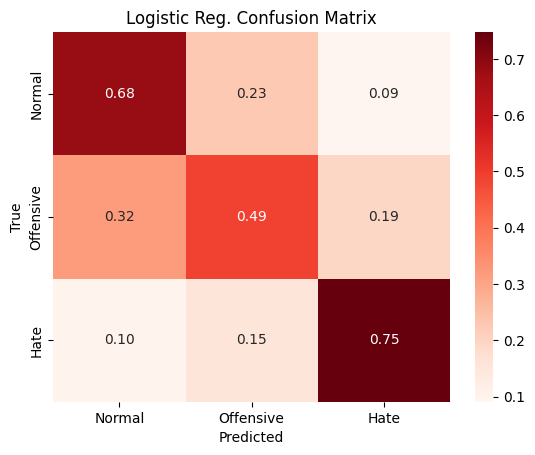

In [53]:
sns.heatmap(cm,annot=True,fmt=".2f",xticklabels=["Normal", "Offensive", "Hate"],yticklabels=["Normal", "Offensive", "Hate"],cmap="Reds")
plt.title("Logistic Reg. Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("../figures/tfidf_logregs.png",dpi=300,bbox_inches="tight" )
plt.show()


### Saving the model

In [38]:
import joblib

joblib.dump(Tfidf_Pipeline,"../models/tfidf/tfidf_logreg.pkl")

['../models/tfidf/tfidf_logreg.pkl']

### Observing Misclassifications

In [39]:
errana_df = test_df.copy()

In [40]:
errana_df["predicted"] = y_pred
errana_df["correct"] = errana_df["label"]==errana_df["predicted"]

In [41]:
temp_err = errana_df[~errana_df["correct"]].copy()
temp_err.shape

(678, 6)

In [42]:
hate_as_off = temp_err[(temp_err["label"] == "hatespeech") &(temp_err["predicted"] == "offensive")]

off_as_hate = temp_err[(temp_err["label"] == "offensive") &(temp_err["predicted"] == "hatespeech")]

normal_as_off = temp_err[(temp_err["label"] == "normal") & (temp_err["predicted"] == "offensive")]


In [ ]:
hate_as_off.sample(5, random_state=42)[["text", "label", "predicted"]]

,text,label,predicted
782,need calm stop autistic like honestly im retar...,hatespeech,offensive
436,democratic party party jews jew causes minorit...,hatespeech,offensive
1141,future face country dumb sexually confused hyp...,hatespeech,offensive
1888,atomaweapon puny faggot trying big shit asking...,hatespeech,offensive
8,education marxist indoctrination since well es...,hatespeech,offensive


In [ ]:
off_as_hate.sample(5, random_state=42)[["text", "label", "predicted"]]

,text,label,predicted
1823,yep going people would listen people like tomm...,offensive,hatespeech
214,well least mudslimes occasionally get right co...,offensive,hatespeech
95,hope remembered defending mudslime instigated ...,offensive,hatespeech
1464,wait ur tellin not earth not flat niggers plan...,offensive,hatespeech
1804,bet queers hard time typing word pussy shit lo...,offensive,hatespeech


In [47]:
normal_as_off.sample(5, random_state=42)[["text", "label", "predicted"]]

,text,label,predicted
194,david bowie allowed mean black woman drag quee...,normal,offensive
572,muslim handler killary obozo valerie jarrett,normal,offensive
1544,roflol bunch queers concept good christian kin...,normal,offensive
385,dude white trash crew shirt almost swung coupl...,normal,offensive
784,day today gym game mattball cause retarded ass,normal,offensive


## Top Hate Features

In [49]:
vect = Tfidf_Pipeline.named_steps["tfidf"]
clf = Tfidf_Pipeline.named_steps["clf"]

features = vect.get_feature_names_out()
features

array(['aa', 'ab', 'abandon', ..., 'zones', 'zoo', 'zuckerberg'],
      shape=(13422,), dtype=object)

In [50]:
hate_index = list(clf.classes_).index("hatespeech")
hate_index

0

In [ ]:
hate_features = sorted(zip(clf.coef_[hate_index], features),reverse=True)[:20]
hate_features

[(np.float64(9.407611572491149), 'nigger'),
 (np.float64(8.749809267521966), 'kike'),
 (np.float64(5.022522135963714), 'niggers'),
 (np.float64(3.3728775783316682), 'muzzie'),
 (np.float64(3.251629767648353), 'spic'),
 (np.float64(3.2408796724535156), 'beaners'),
 (np.float64(3.048748078852573), 'muzzies'),
 (np.float64(2.9132028742544533), 'beaner'),
 (np.float64(2.8022388908091442), 'kikes'),
 (np.float64(2.614910402248068), 'jew'),
 (np.float64(2.5953651073798385), 'raghead'),
 (np.float64(2.5727847082814415), 'moslem'),
 (np.float64(2.4447437918773383), 'mudslime'),
 (np.float64(2.444053847277606), 'muzrat'),
 (np.float64(2.386811809114657), 'coon'),
 (np.float64(2.321581962538354), 'shitskin'),
 (np.float64(2.313755071964319), 'wetback'),
 (np.float64(2.2330527077280555), 'faggots'),
 (np.float64(2.1614282450675764), 'mudslimes'),
 (np.float64(2.136759614190184), 'gook')]